In [478]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [479]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [480]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

## Constants

In [481]:
weight_scale = 1.0
g = 7.0

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 20.0
delay_std = delay_mean * 0.6
v_ext = 0.25

excitatory_type = "ss4"
inhibitory_type = "ss4_I"

## Generate network

In [482]:
G = nx.DiGraph()

# Add 1000 nodes
for i in range(1000):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
excitatory_nodes = random.sample(range(1000), 800)
for i in range(1000):
    if i in excitatory_nodes:
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0
    else:
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw 100 outgoing edges to random nodes
for i in range(1000):
    targets = random.sample(range(1000), 100)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
        else:
            weight = J_E
        delay = max(0.1, np.random.normal(delay_mean, delay_std))
        G.add_edge(i, target, weight=weight, distance=delay)

## Simulation setup

In [483]:
dt = 0.1

In [484]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [485]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

## Simulation

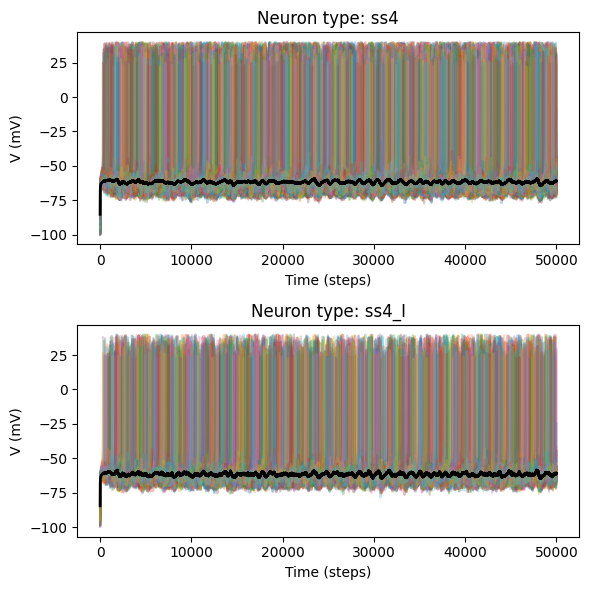

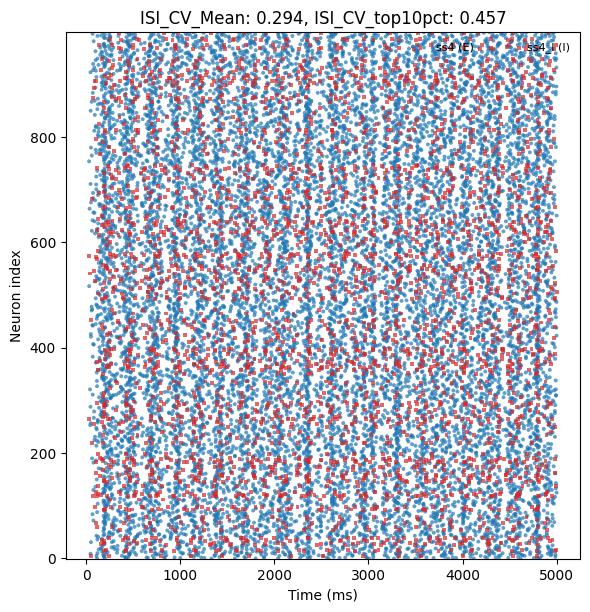

In [486]:

# Randomize initial voltages
Vs = np.random.uniform(-100, -70, size=n_neurons)
us = np.random.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0)

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=1.0)

for i in range(50000):
    sensory_spikes = poisson(dt)
    sim.step(spike_ext=sensory_spikes)
    # sim.step(I_ext=I_ext)

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(6, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}")

In [487]:
sim.stats.compute_metrics(dt, bin_ms_participation=300)

{'rate_mean_Hz': 3.370332593348132,
 'rate_median_Hz': 3.3999320013599723,
 'rate_p95_Hz': 3.9999200015999676,
 'ISI_CV_median': 0.2833631485445122,
 'ISI_CV_mean': 0.2935996574477477,
 'ISI_CV_mean_E': 0.29360434980080446,
 'ISI_CV_mean_I': 0.2935808880355206,
 'ISI_CV_mean_top10pct': 0.45676395768697936,
 'refractory_violations_per_neuron': 0.0,
 'Fano_median_300ms': 0.2222222222222222,
 'mean_noise_corr_50ms': 0.024224432741608664,
 'participation_frac_mean_300ms': 0.8803125,
 'participation_frac_median_300ms': 0.88,
 'participation_frac_p95_300ms': 0.9157500000000001,
 'participation_frac_total': 1.0,
 'pop_spec_entropy': 9.565913163006927,
 'pop_psd_freq_hz': array([0.00000000e+00, 1.99996000e-01, 3.99992000e-01, ...,
        4.99950001e+03, 4.99970001e+03, 4.99990000e+03]),
 'pop_psd': array([3.13226519e-25, 1.00372355e+04, 1.93059810e+04, ...,
        9.55312949e+03, 3.00105556e+03, 4.26870178e+03])}

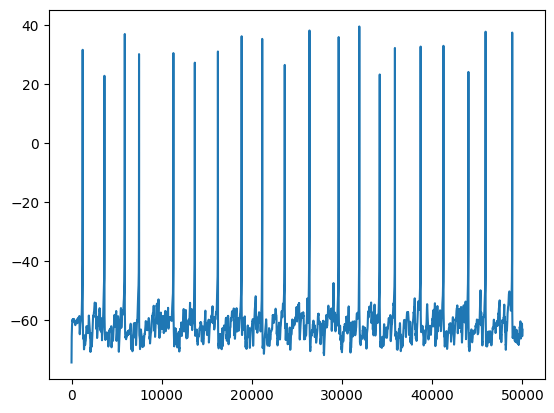

In [493]:
# Plot spikes for one neuron
plt.plot(np.array(sim.stats.Vs)[:,123])

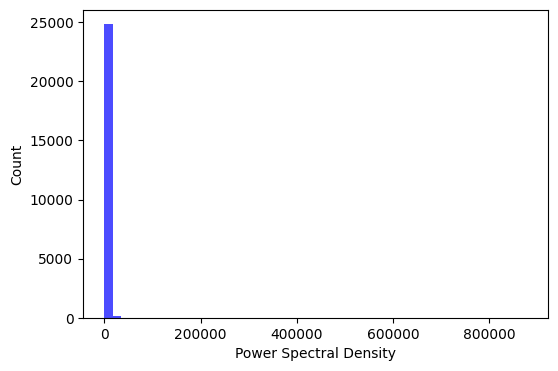

In [489]:
# Histogram of pop_psd
plt.figure(figsize=(6, 4))
plt.hist(sim.stats.compute_metrics(dt)['pop_psd'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Power Spectral Density')
plt.ylabel('Count')
plt.show()

## Grid search